# Lab 4

## Exercise 1

For this exercise, the images 1.bmp and 15.bmp from the subdirectory right_thumb and the images 1.bmp and 12.bmp from the subdirectory left_thumb of the folder BTLab_Fingerprints were used. The following two code snippets are used to compare the number of minutiae and singularities that were found when no equalization was used and when adaptive equalization histogram was used. 

In the first code snippet, no adaptive equalization histogram was applied to the original fingerprint images. The code is used to load 4 images (two images of the right thumb and two images of the left thumb) that are then used as arguments for the function fingerprint_processing along with a block_size = 16 and seg_threshold = 0.2 as the other arguments. The 4 images are pre-processed, and the number of minutiae and singularities found are printed for each fingerprint image. The 4 original fingerprints are then displayed as plots. Lastly, the histogram of the pixel intensity of each of the original fingerprint images are displayed.
1. For the right fingerprint in 1.bmp, the pre-processing detected 50 minutiae and 4 singularities.
2. For the right fingerprint in 15.bmp, the pre-processing detected 78 minutiae and 4 singularities.
3. For the left fingerprint in 1.bmp, the pre-processing detected 65 minutiae and 4 singularities.
4. For the left fingerprint in 12.bmp, the pre-processing detected 55 minutiae and 4 singularities.

In the second code snippet, the adaptive equalization histogram was applied to the original fingerprint images. I decided to apply the adaptive equalization histogram rather than the regular equalization histogram as the adaptive equalization histogram presented a better pixel intensity distirbution when compared to the regular equalization histogram. I found that the adaptive equalization histogram worked better than the regular equalization histogram in this case. The code is used to load 4 images (two images of the right thumb and two images of the left thumb) that are then first put into the function equalize_adapthist (to apply adaptive equalization histogram). The images produced after applying the adaptive equalization histogram are then used as arguments for the function fingerprint_processing along with a block_size = 16 and seg_threshold = 0.2 as the other arguments. The 4 images are pre-processed, and the number of minutiae and singularities found are printed for each fingerprint image. The 4 original fingerprints are displayed as plots and below each of the images, the histogram of the pixel intensity of each of the fingerprint images are displayed. Below these histograms, the images of the fingerprints after the adaptive equalization histogram has been applied are displayed. Lastly, the pixel intensity of the fingerprint images that have had the adaptive equalization histogram applied are displayed as a histogram. 
1. For the right fingerprint in 1.bmp, the pre-processing detected 65 minutiae and 4 singularities.
2. For the right fingerprint in 15.bmp, the pre-processing detected 81 minutiae and 4 singularities.
3. For the left fingerprint in 1.bmp, the pre-processing detected 107 minutiae and 4 singularities.
4. For the left fingerprint in 12.bmp, the pre-processing detected 63 minutiae and 4 singularities.

The right fingerprint in 1.bmp had 50 minutiae and 4 singularities detected when adaptive equalization histogram was not applied and 1.bmp had 65 minutiae and 4 singularities detected when adaptive equalization histogram was applied. The right fingerprint in 15.bmp had 78 minutiae and 4 singularities detected when adaptive equalization histogram was not applied and 15.bmp had 81 minutiae and 4 singularities detected when adaptive equalization histogram was applied. The left fingerprint in 1.bmp had 65 minutiae and 4 singularities detected when adaptive equalization histogram was not applied and 1.bmp had 107 minutiae and 4 singularities detected when adaptive equalization histogram was applied. The left fingerprint in 12.bmp had 55 minutiae and 4 singularities detected when adaptive equalization histogram was not applied and 12.bmp had 63 minutiae and 4 singularities detected when adaptive equalization histogram was applied. As can be seen from these results, whether the adaptive equalization histogram was applied or not, the amount of singularities found between the two code snippets was the exact same. The amount of singularities found was 4 regardless of whether adaptive equalization histogram had been applied or not. However, the adaptive equalization histogram had a great effect on the number of minutiae found. There were significantly more minutiae found when the  equalization was applied to the image before performing the pre-processing. The adaptive equalization histogram clearly helped in increasing the number of minutiae found and can be quite helpful if more contrast is required for the fingerprint images (the difference in contrast is quite noticeable when comparing the original fingerprint images and the images that had the adaptive equalization histogram applied to them as shown under the second code snippet). 

All code was taken from the Lab04-2023W-updated Feb 3 and Lab04-Fingerprint1 on D2L. 

C:\Users\sanch\AppData\Local\Temp\ipykernel_13280\19276411.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


Total of minutiae detected: 50
Total of singularities detected: 4
Total of minutiae detected: 78
Total of singularities detected: 4
Total of minutiae detected: 65
Total of singularities detected: 4
Total of minutiae detected: 55
Total of singularities detected: 4


Text(0.5, 0, 'Pixel intensity')

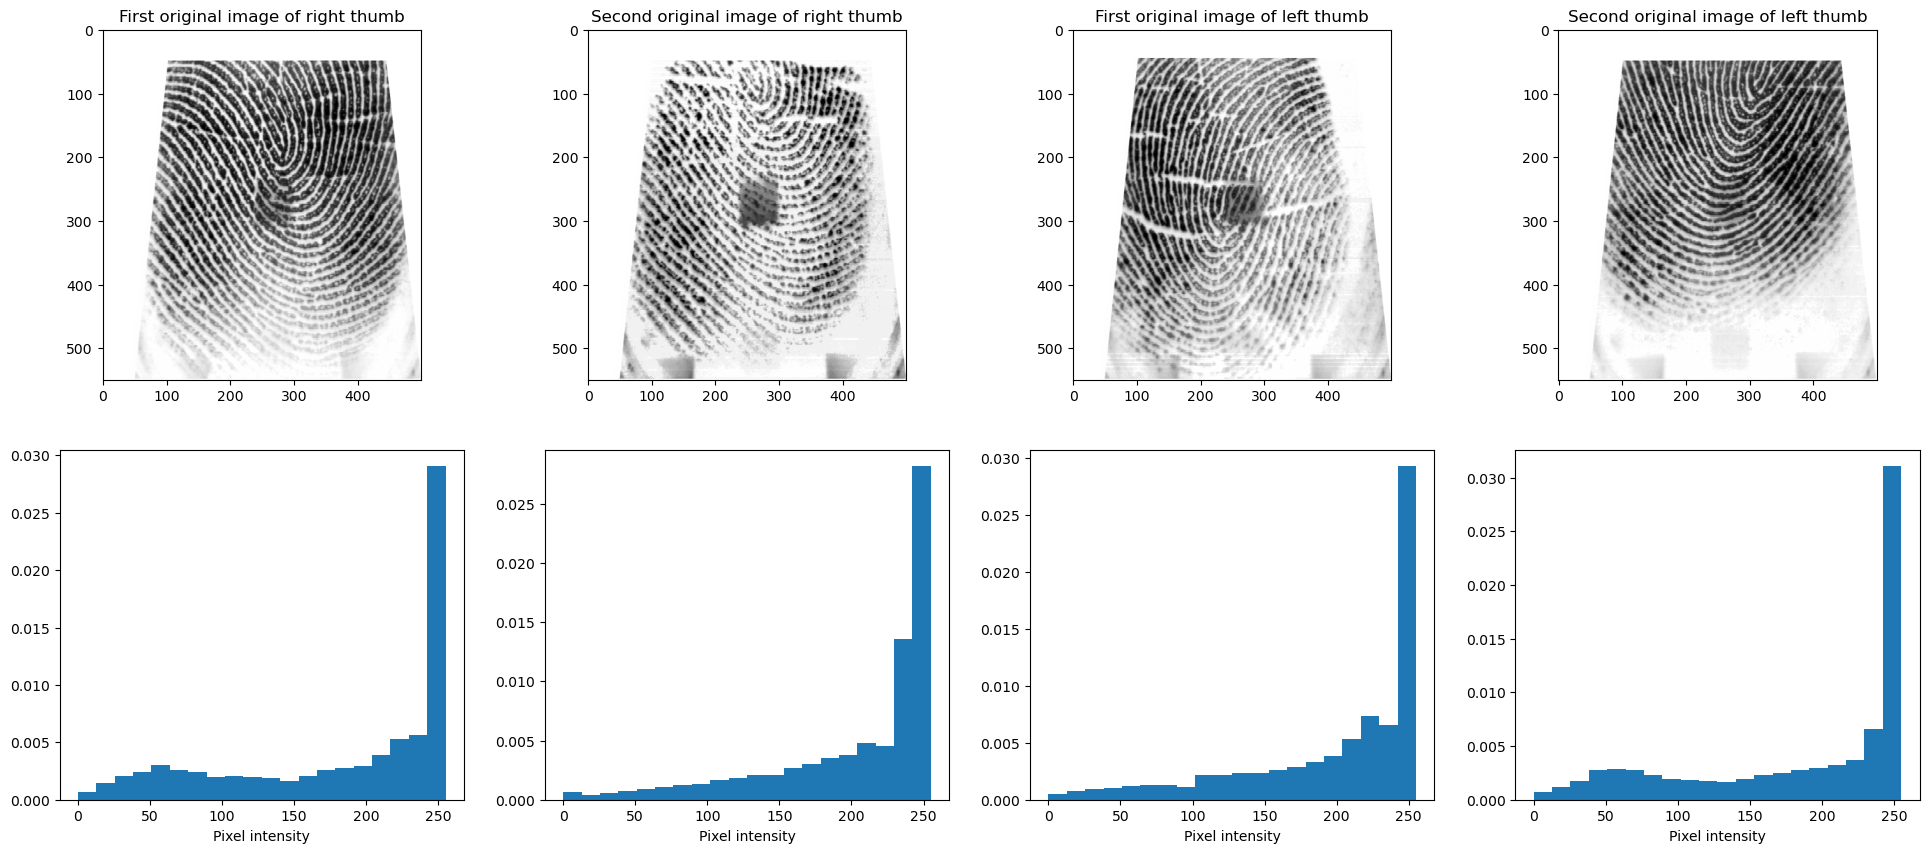

In [23]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
# Pick two images of the right thumb with a difference in quality between the two images
img1_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
img2_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

# Pick two images of the left thumb with a difference in quality between the two images
img1_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))
img2_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/12.bmp', as_gray=True))

# block size usend for windowed processing
block_size = 16

# for segmentation
seg_threshold = 0.2

# copying the original image in case to use later on
input_img1 = img1_right.copy()
input_img2 = img2_right.copy()
input_img3 = img1_left.copy()
input_img4 = img2_left.copy()

# process each fingerprint image (this will also print the number of minutiae and singularities)
Fp1 = fingerprint_processing(img1_right, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img2_right, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img1_left, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img2_left, block_size=block_size, threshold=seg_threshold)

# Plot the original images (the two right thumb and two left thumb images)
plt.figure(figsize=(24,10))
plt.subplot(2,4,1)
plt.imshow(img1_right); plt.title('First original image of right thumb')
plt.subplot(2,4,2)
plt.imshow(img2_right); plt.title('Second original image of right thumb')
plt.subplot(2,4,3)
plt.imshow(img1_left); plt.title('First original image of left thumb')
plt.subplot(2,4,4)
plt.imshow(img2_left); plt.title('Second original image of left thumb')

# below each image, plot the histogram of the pixel intensity of each image
plt.subplot(2,4,5)
plt.hist(img1_right.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,4,6)
plt.hist(img2_right.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,4,7)
plt.hist(img1_left.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,4,8)
plt.hist(img2_left.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

C:\Users\sanch\AppData\Local\Temp\ipykernel_13280\3957603289.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


Total of minutiae detected: 65
Total of singularities detected: 4
Total of minutiae detected: 81
Total of singularities detected: 4
Total of minutiae detected: 107
Total of singularities detected: 4
Total of minutiae detected: 63
Total of singularities detected: 4


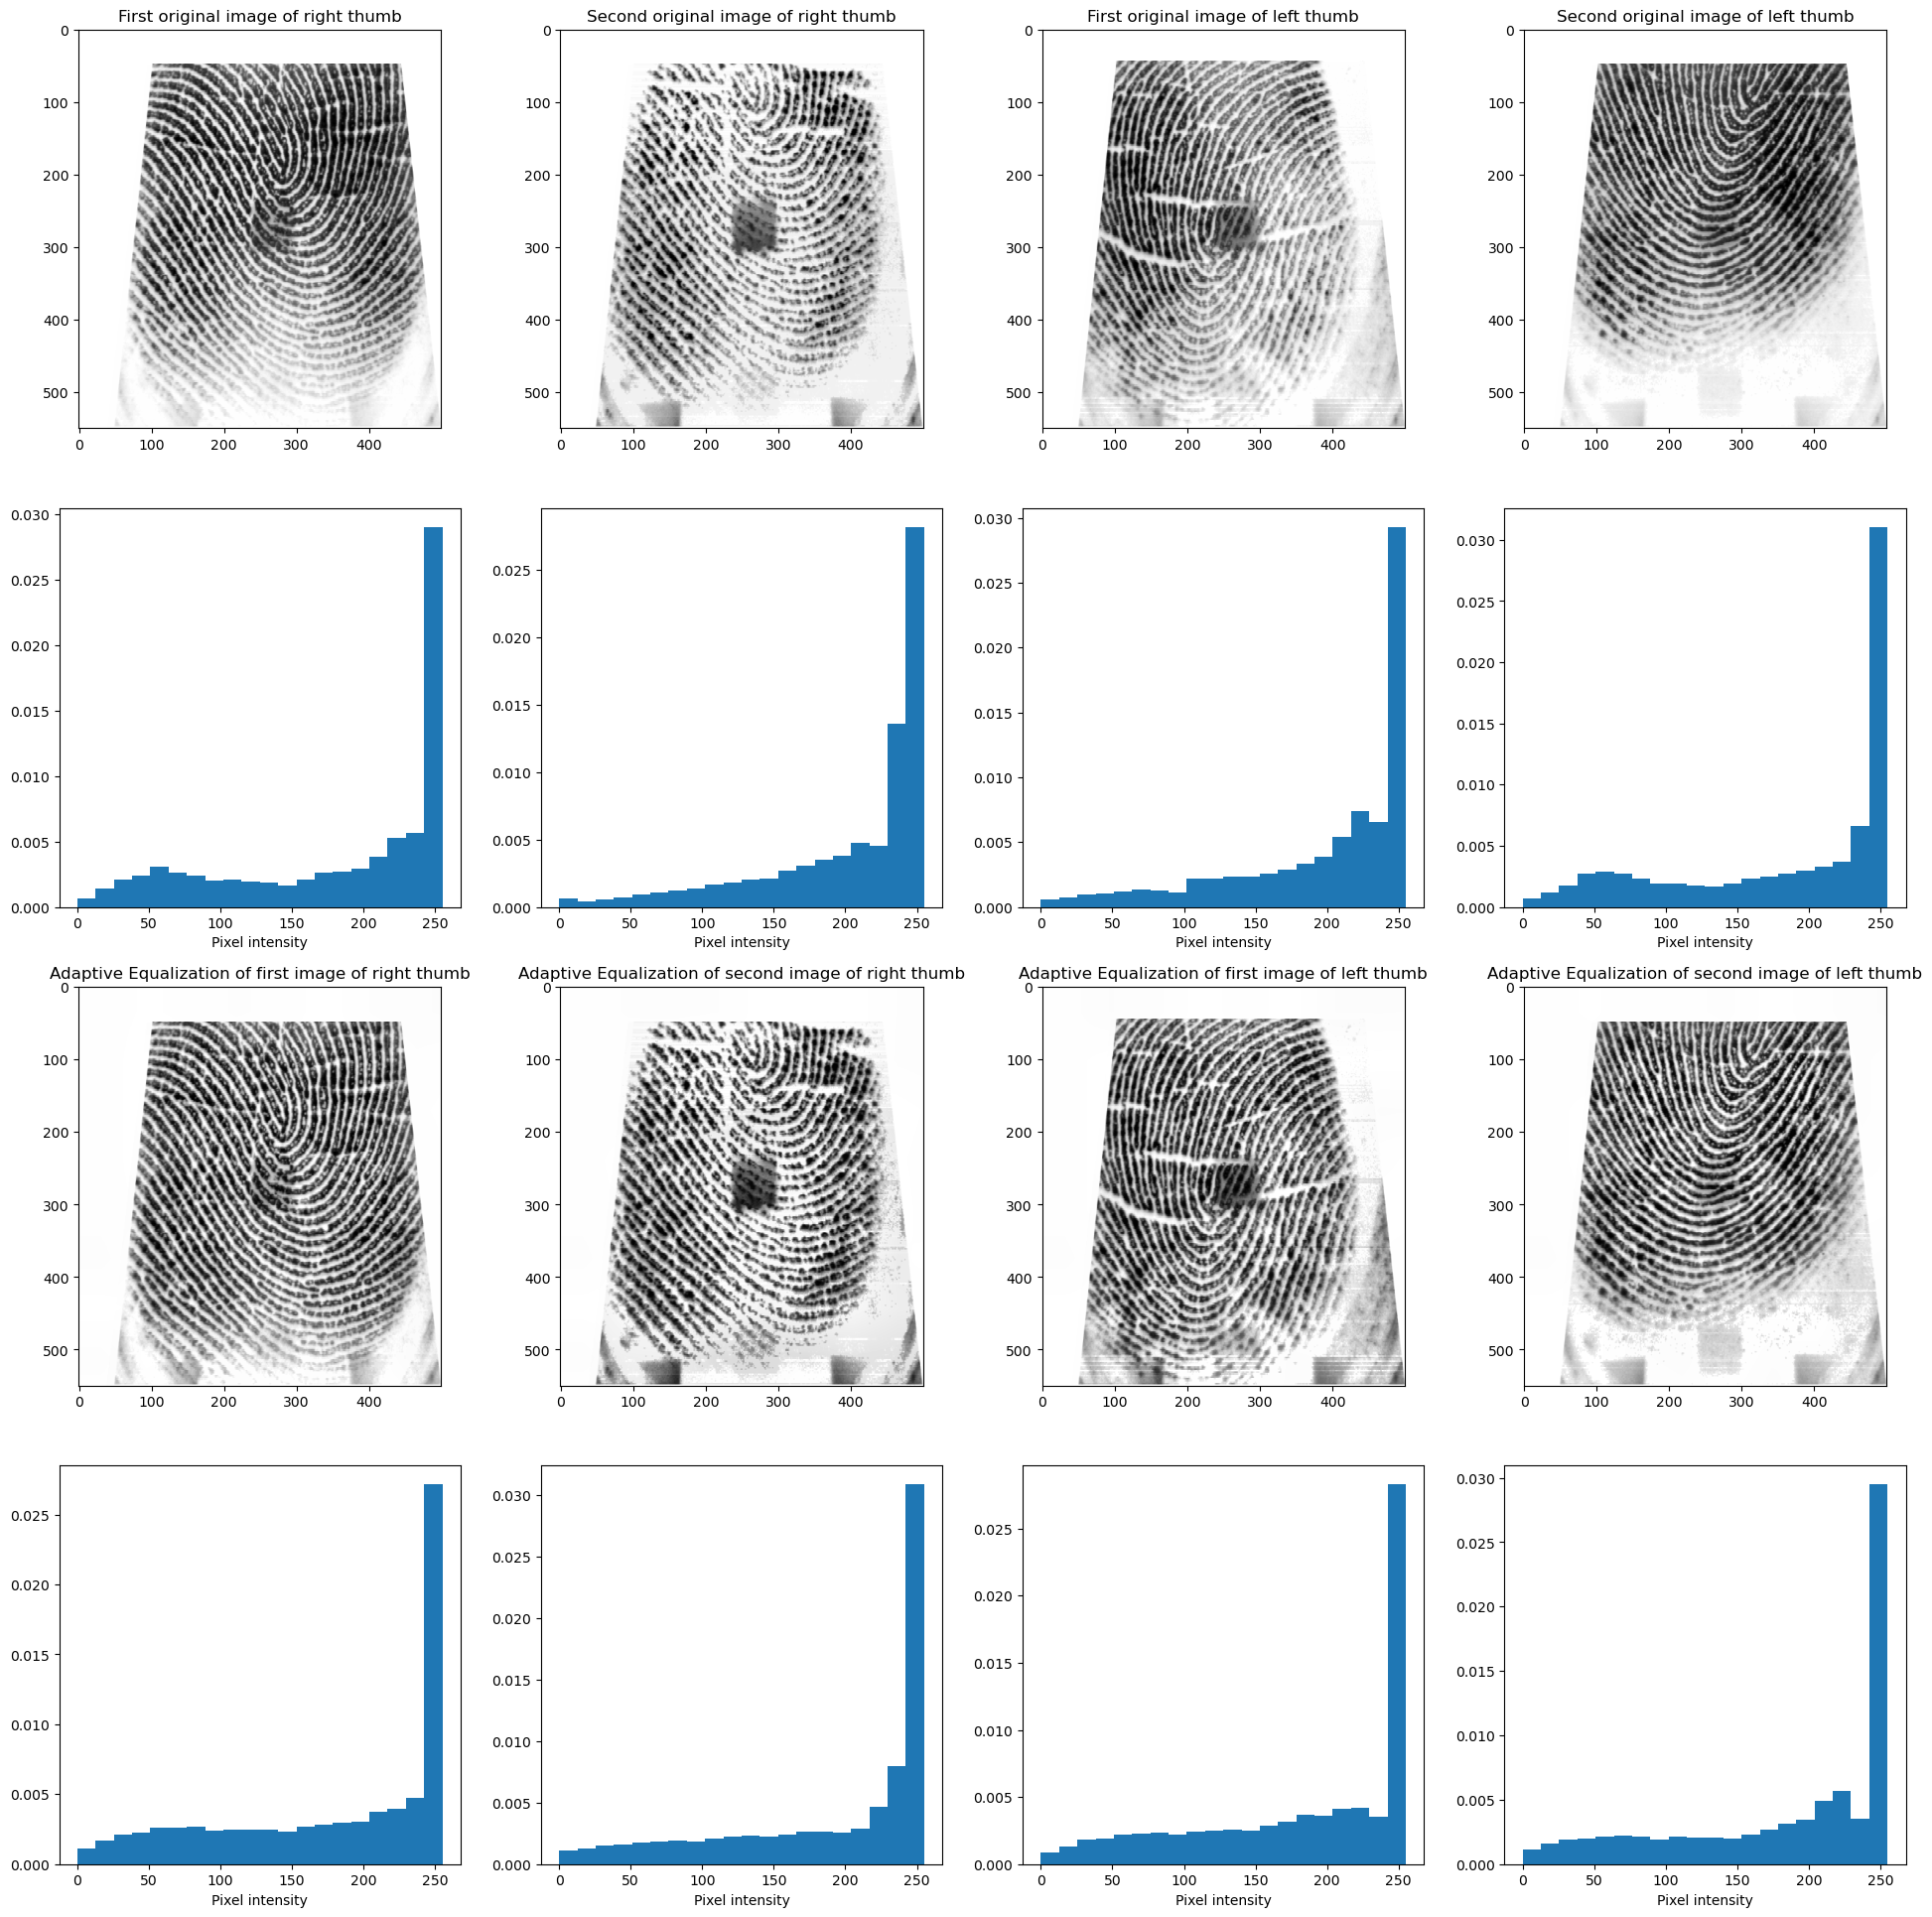

In [24]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
# Pick two images of the right thumb with a difference in quality between the two images
img1_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
img2_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

# Pick two images of the left thumb with a difference in quality between the two images
img1_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))
img2_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/12.bmp', as_gray=True))

# block size usend for windowed processing
block_size = 16

# for segmentation
seg_threshold = 0.2

# copying the original image in case to use later on
input_img1 = img1_right.copy()
input_img2 = img2_right.copy()
input_img3 = img1_left.copy()
input_img4 = img2_left.copy()

# use the adaptive equalization histogram on each fingerprint
img_aeq1 = img_as_ubyte(equalize_adapthist(input_img1))
img_aeq2 = img_as_ubyte(equalize_adapthist(input_img2))
img_aeq3 = img_as_ubyte(equalize_adapthist(input_img3))
img_aeq4 = img_as_ubyte(equalize_adapthist(input_img4))

# process each fingerprint image that was adaptively equalized above (this will also print the number of minutiae and singularities)
Fp1 = fingerprint_processing(img_aeq1, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img_aeq2, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img_aeq3, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img_aeq4, block_size=block_size, threshold=seg_threshold)

# plot the original images (two of the right thumb and two of the left thumb)
plt.figure(figsize=(24,24))
plt.subplot(4,4,1)
plt.imshow(img1_right); plt.title('First original image of right thumb')
plt.subplot(4,4,2)
plt.imshow(img2_right); plt.title('Second original image of right thumb')
plt.subplot(4,4,3)
plt.imshow(img1_left); plt.title('First original image of left thumb')
plt.subplot(4,4,4)
plt.imshow(img2_left); plt.title('Second original image of left thumb')

# below each image, plot the histogram of the pixel intensity of each image
plt.subplot(4,4,5)
plt.hist(img1_right.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(4,4,6)
plt.hist(img2_right.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(4,4,7)
plt.hist(img1_left.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(4,4,8)
plt.hist(img2_left.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

# plot the adaptively equalized images (two of the right thumb and two of the left thumb)
plt.subplot(4,4,9)
plt.imshow(img_aeq1); plt.title('Adaptive Equalization of first image of right thumb');
plt.subplot(4,4,10)
plt.imshow(img_aeq2); plt.title('Adaptive Equalization of second image of right thumb');
plt.subplot(4,4,11)
plt.imshow(img_aeq3); plt.title('Adaptive Equalization of first image of left thumb');
plt.subplot(4,4,12)
plt.imshow(img_aeq4); plt.title('Adaptive Equalization of second image of left thumb');

# below each of those images, plot the adatively equalized histogram of the pixel intensity of each image
plt.subplot(4,4,13)
plt.hist(img_aeq1.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');
plt.subplot(4,4,14)
plt.hist(img_aeq2.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');
plt.subplot(4,4,15)
plt.hist(img_aeq3.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');
plt.subplot(4,4,16)
plt.hist(img_aeq4.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

## Exercise 2

For this exercise, the images 1.bmp and 15.bmp from the subdirectory right_thumb and the images 1.bmp and 12.bmp from the subdirectory left_thumb of the folder BTLab_Fingerprints were used. The following two code snippets are used to compare the number of minutiae and singularities that were found when no de-noising filter was used and when the median de-noising filter was used. 

In the first code snippet, no de-noising filter was applied to the original fingerprint images. The code is used to load 4 images (two images of the right thumb and two images of the left thumb) that are then used as arguments for the function fingerprint_processing along with a block_size = 16 and seg_threshold = 0.2 as the other arguments. The 4 images are pre-processed, and the number of minutiae and singularities found are printed for each fingerprint image. The 4 original fingerprints are then displayed as plots.
1. For the right fingerprint in 1.bmp, the pre-processing detected 50 minutiae and 4 singularities.
2. For the right fingerprint in 15.bmp, the pre-processing detected 78 minutiae and 4 singularities.
3. For the left fingerprint in 1.bmp, the pre-processing detected 65 minutiae and 4 singularities.
4. For the left fingerprint in 12.bmp, the pre-processing detected 55 minutiae and 4 singularities.

In the second code snippet, the median de-noising filter was applied to the original fingerprint images. I picked only the median de-noising filter rather than using both filters (as mentioned in the file Lab04-Fingerprint1. The code is used to load 4 images (two images of the right thumb and two images of the left thumb) that are then first put into the function median (to apply the median de-noising filter). The images produced after applying the median de-noising filter are then used as arguments for the function fingerprint_processing along with a block_size = 16 and seg_threshold = 0.2 as the other arguments. The 4 images are pre-processed, and the number of minutiae and singularities found are printed for each fingerprint image. The 4 original fingerprints are displayed as plots and below each of the images. Below these images, the images of the fingerprints after the median de-noising filter has been applied are displayed.
1. For the right fingerprint in 1.bmp, the pre-processing detected 35 minutiae and 4 singularities.
2. For the right fingerprint in 15.bmp, the pre-processing detected 61 minutiae and 4 singularities.
3. For the left fingerprint in 1.bmp, the pre-processing detected 60 minutiae and 4 singularities.
4. For the left fingerprint in 12.bmp, the pre-processing detected 42 minutiae and 4 singularities.

The right fingerprint in 1.bmp had 50 minutiae and 4 singularities detected when the median de-noising filter was not applied and 1.bmp had 35 minutiae and 4 singularities detected when the median de-noising filter was applied. The right fingerprint in 15.bmp had 78 minutiae and 4 singularities detected when the median de-noising filter was not applied and 15.bmp had 61 minutiae and 4 singularities detected when the median de-noising filter was applied. The left fingerprint in 1.bmp had 65 minutiae and 4 singularities detected when the median de-noising filter was not applied and 1.bmp had 60 minutiae and 4 singularities detected when the median de-noising filter was applied. The left fingerprint in 12.bmp had 55 minutiae and 4 singularities detected when the median de-noising filter was not applied and 12.bmp had 42 minutiae and 4 singularities detected when the median de-noising filter was applied. From these results, whether the median de-noising filter was applied or not, the amount of singularities found between the two code snippets was the exact same. The amount of singularities found was 4 regardless of whether the median de-noising filter had been applied or not. However, the median de-noising filter had a great effect on the number of minutiae found. There were significantly less minutiae found when the filter was applied to the image before performing the pre-processing. The median de-noising filter clearly decreased the number of minutiae found by removing the noise from the original fingerprint images. It may help by removing extraneous pixel intensities and therefore greatly affect the number of minutiae found.

All code was taken from the Lab04-2023W-updated Feb 3 and Lab04-Fingerprint1 on D2L. 

C:\Users\sanch\AppData\Local\Temp\ipykernel_13280\2181719919.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


Total of minutiae detected: 50
Total of singularities detected: 4
Total of minutiae detected: 78
Total of singularities detected: 4
Total of minutiae detected: 65
Total of singularities detected: 4
Total of minutiae detected: 55
Total of singularities detected: 4


Text(0.5, 1.0, 'Second original image of left thumb')

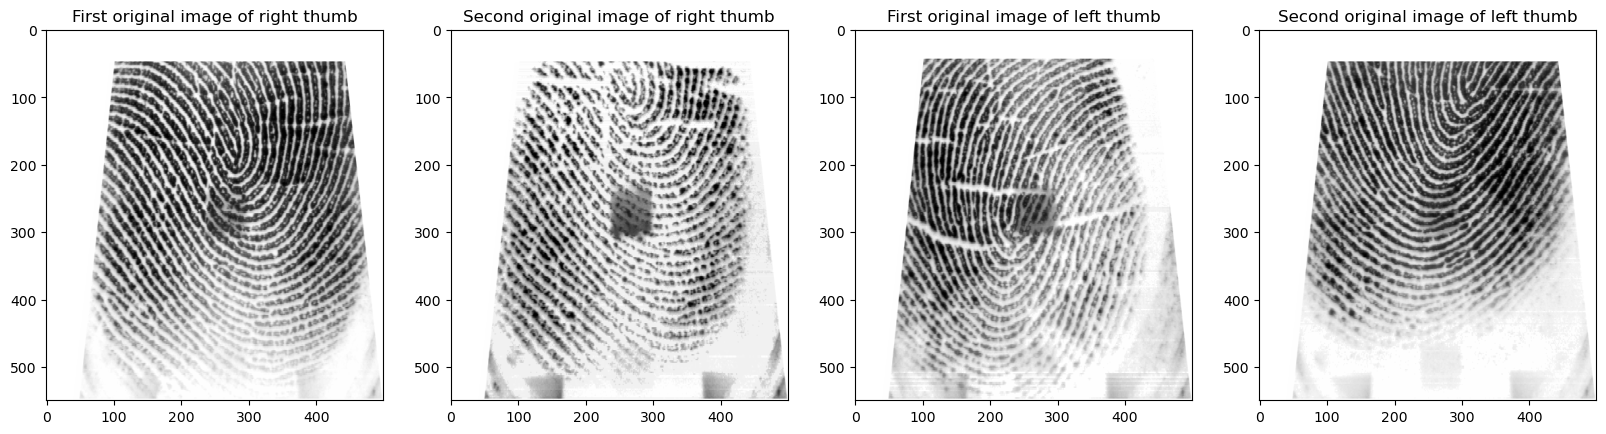

In [25]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
# Pick two images of the right thumb with a difference in quality between the two images
img1_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
img2_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

# Pick two images of the left thumb with a difference in quality between the two images
img1_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))
img2_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/12.bmp', as_gray=True))

# block size usend for windowed processing
block_size = 16

# for segmentation
seg_threshold = 0.2

# copying the original image in case to use later on
input_img1 = img1_right.copy()
input_img2 = img2_right.copy()
input_img3 = img1_left.copy()
input_img4 = img2_left.copy()

# process each original fingerprint (this will also print the number of minutiae and singularities)
Fp1 = fingerprint_processing(img1_right, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img2_right, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img1_left, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img2_left, block_size=block_size, threshold=seg_threshold)

# plot each of the original fingerprint images (two of the right thumb and two of the left thumb)
plt.figure(figsize=(20,15))
plt.subplot(1,4,1)
plt.imshow(img1_right); plt.title('First original image of right thumb')
plt.subplot(1,4,2)
plt.imshow(img2_right); plt.title('Second original image of right thumb')
plt.subplot(1,4,3)
plt.imshow(img1_left); plt.title('First original image of left thumb')
plt.subplot(1,4,4)
plt.imshow(img2_left); plt.title('Second original image of left thumb')

C:\Users\sanch\AppData\Local\Temp\ipykernel_13280\2272465687.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


Total of minutiae detected: 35
Total of singularities detected: 4
Total of minutiae detected: 61
Total of singularities detected: 4
Total of minutiae detected: 60
Total of singularities detected: 4
Total of minutiae detected: 42
Total of singularities detected: 4


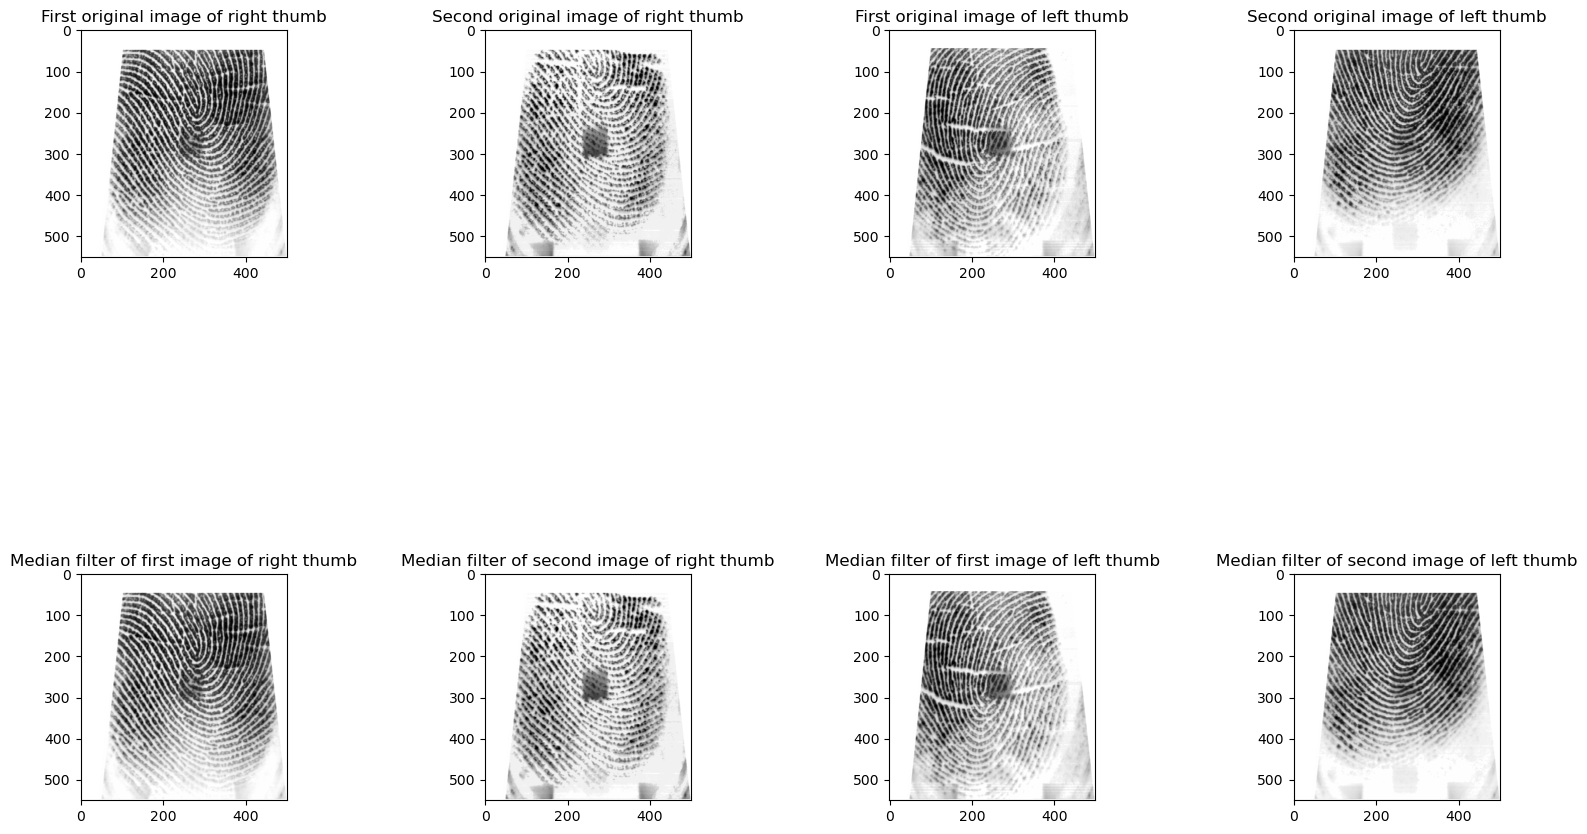

In [32]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
# Pick two images of the right thumb with a difference in quality between the two images
img1_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
img2_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

# Pick two images of the left thumb with a difference in quality between the two images
img1_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))
img2_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/12.bmp', as_gray=True))

# block size usend for windowed processing
block_size = 16

# for segmentation
seg_threshold = 0.2

# copying the original image in case to use later on
input_img1 = img1_right.copy()
input_img2 = img2_right.copy()
input_img3 = img1_left.copy()
input_img4 = img2_left.copy()

# with the Median filter is not necessary to convert back to uint8 
# use the median filter on each original image (two of the right thumb and two of the left thumb)
img_median1 = median(img1_right)
img_median2 = median(img2_right)
img_median3 = median(img1_left)
img_median4 = median(img2_left)

# process each of the fingerprint images that had the median filter applied (this will also print the number of minutiae and singularities)
Fp1 = fingerprint_processing(img_median1, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img_median2, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img_median3, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img_median4, block_size=block_size, threshold=seg_threshold)

# plot each of the original images (two of the right thumb and two of the left thumb)
plt.figure(figsize=(20,10))
plt.subplot(3,4,1)
plt.imshow(img1_right); plt.title('First original image of right thumb')
plt.subplot(3,4,2)
plt.imshow(img2_right); plt.title('Second original image of right thumb')
plt.subplot(3,4,3)
plt.imshow(img1_left); plt.title('First original image of left thumb')
plt.subplot(3,4,4)
plt.imshow(img2_left); plt.title('Second original image of left thumb')

# plot each of the fingerprint images with the median filter applied to them
plt.subplot(3,4,9)
plt.imshow(img_median1); plt.title('Median filter of first image of right thumb');
plt.subplot(3,4,10)
plt.imshow(img_median2); plt.title('Median filter of second image of right thumb');
plt.subplot(3,4,11)
plt.imshow(img_median3); plt.title('Median filter of first image of left thumb');
plt.subplot(3,4,12)
plt.imshow(img_median4); plt.title('Median filter of second image of left thumb');

## Exercise 3

I separated this exercise into two section: Exercise 3.a and Exercise 3.b. 

Exercise 3.a goes over the differences in minutiae and singularities detected when block_size and seg_threshold are changed respectively. There are three sets of minutiae and singularities detected for the four fingerprints: one where block_size is 15 and seg_threshold is 0.4 (the baseline/reference values), one where block_size is changed to 20 and seg_threshold remains 0.4, and one where seg_threshold is changed to 0.5 and block_size remains 15. 

On the other hand, Exercise 3.b displays the differences in minutiae and singularities detected when block_size is held constant  at a value of 16 and seg_threshold is changed twice. There are two sets of minutiae and singularities detected for the four fingerprints: one where block_size is 16 and seg_threshold is 0.2 and one where block_size remains 16 and seg_threshold is changed to 0.7. Exercise 3.b can be found directly under the three code snippets under Exercise 3.a. 

The results and conclusions drawn are displayed in their respective sections.

### Exercise 3.a

For this exercise, the images 1.bmp and 15.bmp from the subdirectory right_thumb and the images 1.bmp and 12.bmp from the subdirectory left_thumb of the folder BTLab_Fingerprints were used. The following three code snippets are used to find the effects of changing the block_size and seg_threshold that are used in the function fingerprint_processing. The original images of the 4 fingerprints are also displayed below each code snippet. 

The first code snippet is used as a baseline/reference. The block_size is 15 and the seg_threshold is 0.4. Using this block_size and seg_threshold, the number of minutiae and singularities found is:
1. For the right fingerprint in 1.bmp, the pre-processing detected 96 minutiae and 4 singularities.
2. For the right fingerprint in 15.bmp, the pre-processing detected 97 minutiae and 4 singularities.
3. For the left fingerprint in 1.bmp, the pre-processing detected 96 minutiae and 4 singularities.
4. For the left fingerprint in 12.bmp, the pre-processing detected 80 minutiae and 4 singularities.

The second code snippet changes the block_size to 20 while the seg_threshold is kept at 0.4. Using this block_size and seg_threshold, the number of minutiae and singularities found is:
1. For the right fingerprint in 1.bmp, the pre-processing detected 38 minutiae and 4 singularities.
2. For the right fingerprint in 15.bmp, the pre-processing detected 73 minutiae and 4 singularities.
3. For the left fingerprint in 1.bmp, the pre-processing detected 61 minutiae and 4 singularities.
4. For the left fingerprint in 12.bmp, the pre-processing detected 49 minutiae and 4 singularities.

The third code snippet changes the seg_threshold to 0.5 while the block_size is kept at 15. Using this block_size and seg_threshold, the number of minutiae and singularities found is:
1. For the right fingerprint in 1.bmp, the pre-processing detected 95 minutiae and 4 singularities.
2. For the right fingerprint in 15.bmp, the pre-processing detected 91 minutiae and 2 singularities.
3. For the left fingerprint in 1.bmp, the pre-processing detected 64 minutiae and 0 singularities.
4. For the left fingerprint in 12.bmp, the pre-processing detected 81 minutiae and 4 singularities.

As can be seen in the results, changing block_size seems to change the number of minutiae found quite significantly. Changing block_size from 15 to 20 changes the number of minutiae detected from 96 to 38 for the right fingerprint in 1.bmp, from 97 to 73 for the right fingerprint in 15.bmp, from 96 to 61 for the left fingerprint in 1.bmp, and from 80 to 49 for the left fingerprint in 12.bmp. On the other hand, the number of singularities detected does not seem to change when block_size is changed from 15 to 20. Clearly, the block_size has a great effect on the number of minutiae detected while it doesn't seem to effect the number of singularities detected. From this data, increasing block_size reduces the number of minutiate detected while decreasing block_size should then result in an increase in the number of minutiae found. The block_size needs to be set appropriately in order to detect an appropriate amount of minutiae.  

Changing seg_threshold seems to change the number of minutiae and the number of singularities found. Changing seg_threshold from 0.4 to 0.5 changes the number of minutiae detected from 96 to 95 for the right fingerprint in 1.bmp, from 97 to 91 for the right fingerprint in 15.bmp, from 96 to 64 for the left fingerprint in 1.bmp, and from 80 to 81 for the left fingerprint in 12.bmp. The change in seg_threshold also seems to change the number of singularities detected from 4 to 2 for the right fingerprint in 15.bmp and from 4 to 0 for the left fingerprint in 1.bmp. Clearly, the seg_threshold has great effects on the number of minutiae and singularities detected. From this data, increasing seg_threshold seems to overall decrease the number of minutiae found. At the same time, increasing seg_threshold seems to overall lower the number of singularities found. Through these results, it is clearly important to set an appropriate seg_threshold in order to be able to detect a proper amount of minutiae and singularities.

All code was taken from the Lab04-2023W-updated Feb 3 and Lab04-Fingerprint1 on D2L. 

C:\Users\sanch\AppData\Local\Temp\ipykernel_13280\1135995612.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


Total of minutiae detected: 96
Total of singularities detected: 4
Total of minutiae detected: 97
Total of singularities detected: 4
Total of minutiae detected: 96
Total of singularities detected: 4
Total of minutiae detected: 80
Total of singularities detected: 4


Text(0.5, 1.0, 'Second original image of left thumb')

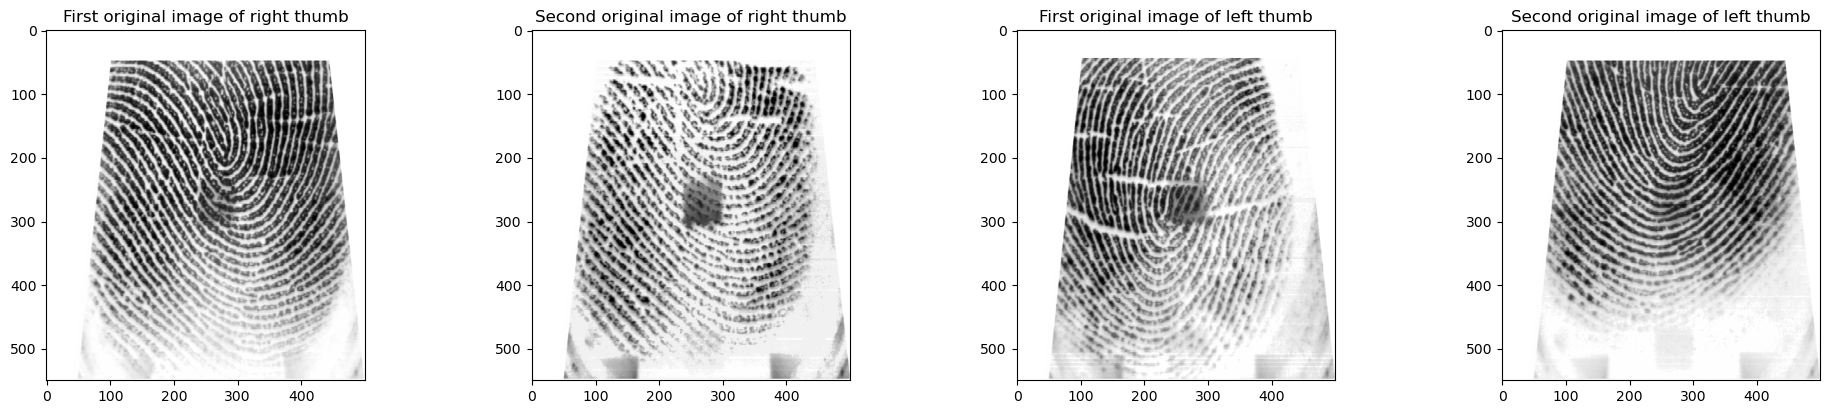

In [39]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
# Pick two images of the right thumb with a difference in quality between the two images
img1_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
img2_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

# Pick two images of the left thumb with a difference in quality between the two images
img1_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))
img2_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/12.bmp', as_gray=True))

# block size usend for windowed processing
block_size = 15

# for segmentation
seg_threshold = 0.4

# copying the original image in case to use later on
input_img1 = img1_right.copy()
input_img2 = img2_right.copy()
input_img3 = img1_left.copy()
input_img4 = img2_left.copy()

# process each fingerprint image (this will also print the number of minutiae and singularities)
Fp1 = fingerprint_processing(img1_right, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img2_right, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img1_left, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img2_left, block_size=block_size, threshold=seg_threshold)

# Plot the original images (the two right thumb and two left thumb images)
plt.figure(figsize=(24,10))
plt.subplot(2,4,1)
plt.imshow(img1_right); plt.title('First original image of right thumb')
plt.subplot(2,4,2)
plt.imshow(img2_right); plt.title('Second original image of right thumb')
plt.subplot(2,4,3)
plt.imshow(img1_left); plt.title('First original image of left thumb')
plt.subplot(2,4,4)
plt.imshow(img2_left); plt.title('Second original image of left thumb')

C:\Users\sanch\AppData\Local\Temp\ipykernel_13280\476215758.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


Total of minutiae detected: 38
Total of singularities detected: 4
Total of minutiae detected: 73
Total of singularities detected: 4
Total of minutiae detected: 61
Total of singularities detected: 4
Total of minutiae detected: 49
Total of singularities detected: 4


Text(0.5, 1.0, 'Second original image of left thumb')

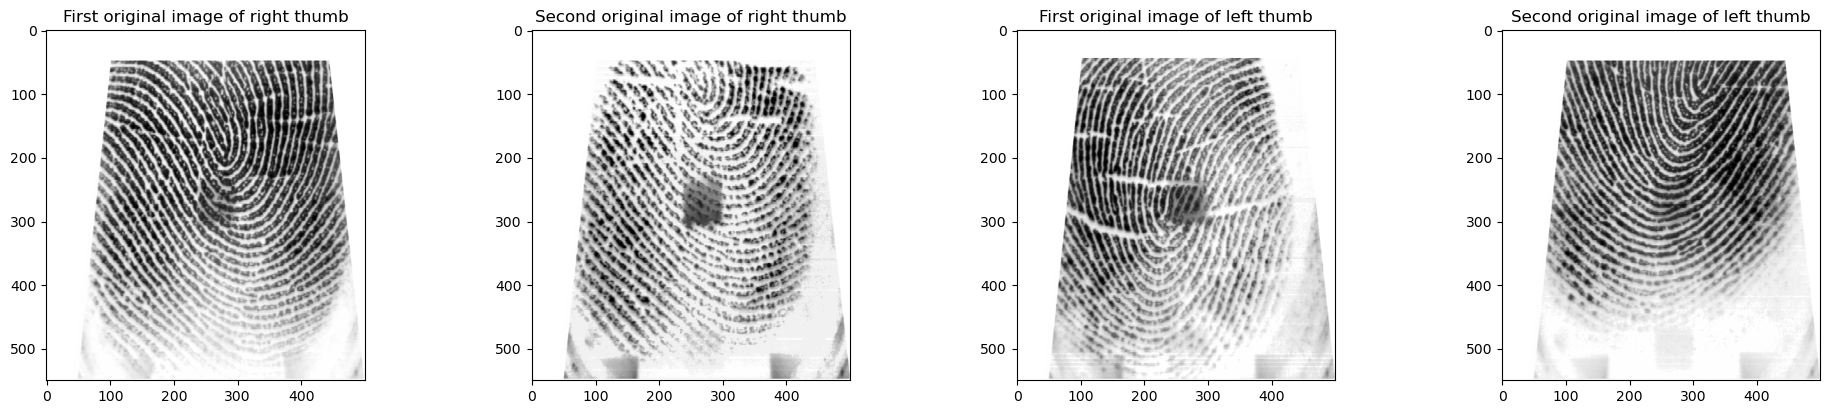

In [34]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
# Pick two images of the right thumb with a difference in quality between the two images
img1_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
img2_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

# Pick two images of the left thumb with a difference in quality between the two images
img1_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))
img2_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/12.bmp', as_gray=True))

# block size usend for windowed processing
block_size = 20

# for segmentation
seg_threshold = 0.4

# copying the original image in case to use later on
input_img1 = img1_right.copy()
input_img2 = img2_right.copy()
input_img3 = img1_left.copy()
input_img4 = img2_left.copy()

# process each fingerprint image (this will also print the number of minutiae and singularities)
Fp1 = fingerprint_processing(img1_right, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img2_right, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img1_left, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img2_left, block_size=block_size, threshold=seg_threshold)

# Plot the original images (the two right thumb and two left thumb images)
plt.figure(figsize=(24,10))
plt.subplot(2,4,1)
plt.imshow(img1_right); plt.title('First original image of right thumb')
plt.subplot(2,4,2)
plt.imshow(img2_right); plt.title('Second original image of right thumb')
plt.subplot(2,4,3)
plt.imshow(img1_left); plt.title('First original image of left thumb')
plt.subplot(2,4,4)
plt.imshow(img2_left); plt.title('Second original image of left thumb')

C:\Users\sanch\AppData\Local\Temp\ipykernel_13280\1995103194.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


Total of minutiae detected: 95
Total of singularities detected: 4
Total of minutiae detected: 91
Total of singularities detected: 2
Total of minutiae detected: 64
Total of singularities detected: 0
Total of minutiae detected: 81
Total of singularities detected: 4


Text(0.5, 1.0, 'Second original image of left thumb')

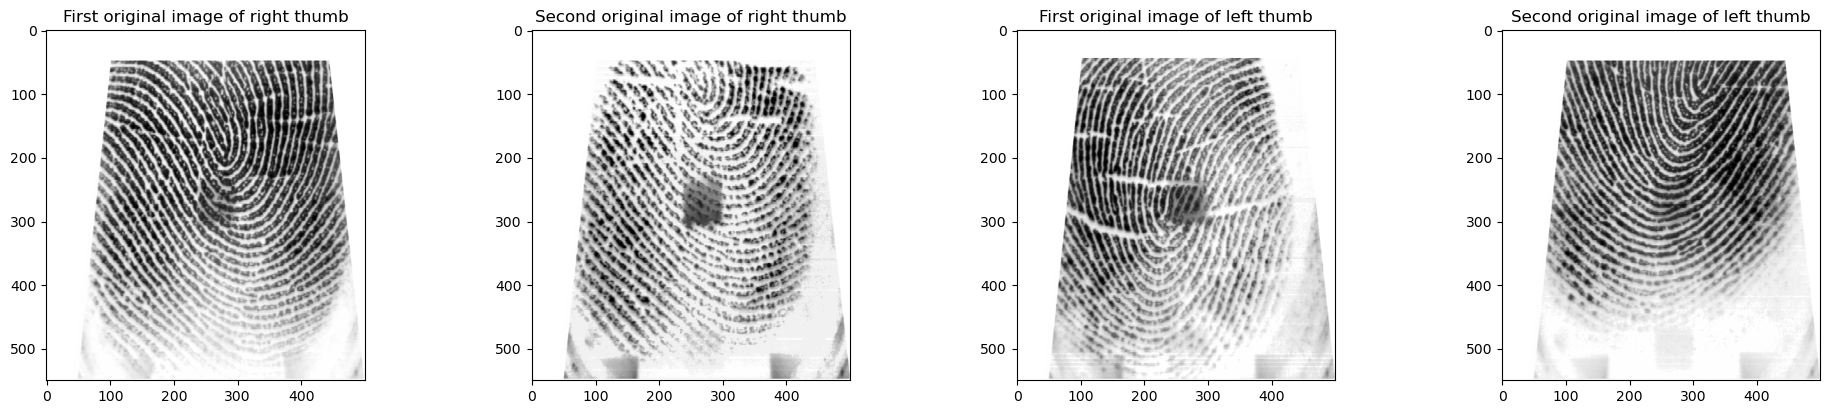

In [41]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
# Pick two images of the right thumb with a difference in quality between the two images
img1_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
img2_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

# Pick two images of the left thumb with a difference in quality between the two images
img1_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))
img2_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/12.bmp', as_gray=True))

# block size usend for windowed processing
block_size = 15

# for segmentation
seg_threshold = 0.5

# copying the original image in case to use later on
input_img1 = img1_right.copy()
input_img2 = img2_right.copy()
input_img3 = img1_left.copy()
input_img4 = img2_left.copy()

# process each fingerprint image (this will also print the number of minutiae and singularities)
Fp1 = fingerprint_processing(img1_right, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img2_right, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img1_left, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img2_left, block_size=block_size, threshold=seg_threshold)

# Plot the original images (the two right thumb and two left thumb images)
plt.figure(figsize=(24,10))
plt.subplot(2,4,1)
plt.imshow(img1_right); plt.title('First original image of right thumb')
plt.subplot(2,4,2)
plt.imshow(img2_right); plt.title('Second original image of right thumb')
plt.subplot(2,4,3)
plt.imshow(img1_left); plt.title('First original image of left thumb')
plt.subplot(2,4,4)
plt.imshow(img2_left); plt.title('Second original image of left thumb')

### Exercise 3.b

For this exercise, the images 1.bmp and 15.bmp from the subdirectory right_thumb and the images 1.bmp and 12.bmp from the subdirectory left_thumb of the folder BTLab_Fingerprints were used. The following two code snippets are used to find the effects of changing seg_threshold while keeping block_size at a constant 16. The original images of the 4 fingerprints are also displayed below each code snippet. 

The first code snippet uses a seg_threshold of 0.2 while keeping block_size at 16. Using this block_size and seg_threshold, the number of minutiae and singularities found is:
1. For the right fingerprint in 1.bmp, the pre-processing detected 50 minutiae and 4 singularities.
2. For the right fingerprint in 15.bmp, the pre-processing detected 78 minutiae and 4 singularities.
3. For the left fingerprint in 1.bmp, the pre-processing detected 65 minutiae and 4 singularities.
4. For the left fingerprint in 12.bmp, the pre-processing detected 55 minutiae and 4 singularities.

The second code snippet changes the seg_threshold to 0.7 while the block_size is kept at 16. Using this block_size and seg_threshold, the number of minutiae and singularities found is:
1. For the right fingerprint in 1.bmp, the pre-processing detected 15 minutiae and 0 singularities.
2. For the right fingerprint in 15.bmp, the pre-processing detected 35 minutiae and 0 singularities.
3. For the left fingerprint in 1.bmp, the pre-processing detected 18 minutiae and 0 singularities.
4. For the left fingerprint in 12.bmp, the pre-processing detected 2 minutiae and 0 singularities.

Changing seg_threshold seems to change the number of minutiae and the number of singularities found significantly. Changing seg_threshold from 0.2 to 0.7 changes the number of minutiae detected from 50 to 15 for the right fingerprint in 1.bmp, from 78 to 35 for the right fingerprint in 15.bmp, from 65 to 18 for the left fingerprint in 1.bmp, and from 55 to 2 for the left fingerprint in 12.bmp. The change in seg_threshold also seems to change the number of singularities detected from 4 to 0 for every fingerprint that was used for these tests. Clearly, the seg_threshold has great effects on the number of minutiae and singularities detected. From this data, increasing seg_threshold seems to signficantly lower the number of minutiae detected. At the same time, the increase in seg_threshold also decreases the amount of singularities found significantly. It becomes impossible to detect any singularities if seg_threshold is increased unreasonably. This must mean that seg_threshold has to be appropriately chosen in order to detect a proper number of minutiae and singularities.

All code was taken from the Lab04-2023W-updated Feb 3 and Lab04-Fingerprint1 on D2L. 

C:\Users\sanch\AppData\Local\Temp\ipykernel_13280\2651725456.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


Total of minutiae detected: 50
Total of singularities detected: 4
Total of minutiae detected: 78
Total of singularities detected: 4
Total of minutiae detected: 65
Total of singularities detected: 4
Total of minutiae detected: 55
Total of singularities detected: 4


Text(0.5, 1.0, 'Second original image of left thumb')

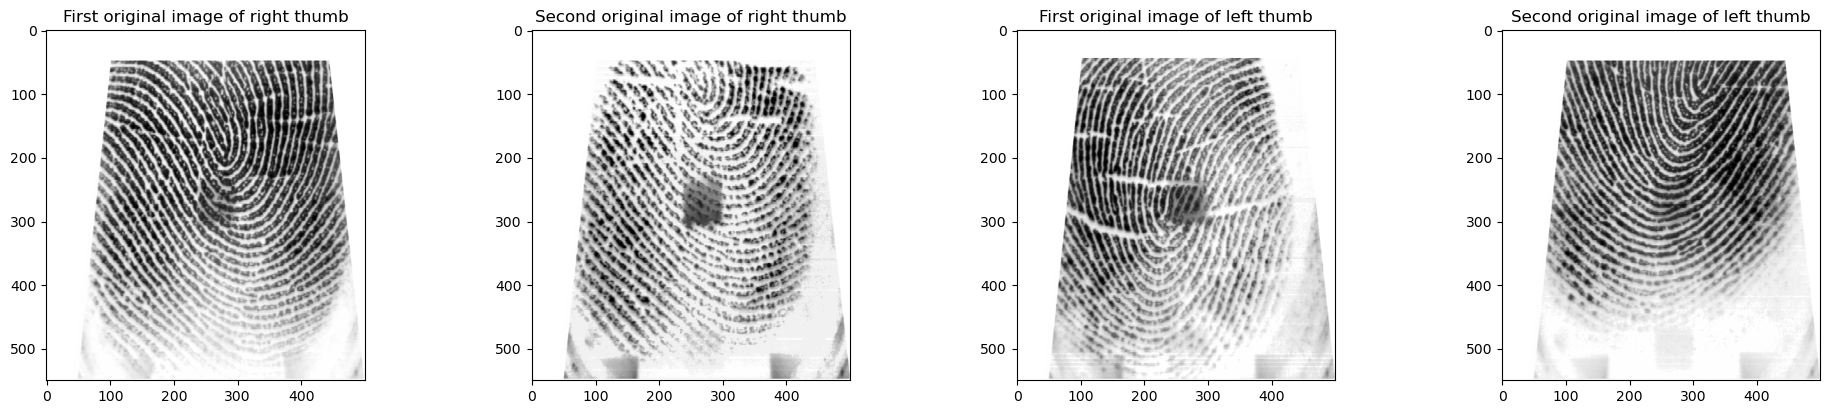

In [37]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
# Pick two images of the right thumb with a difference in quality between the two images
img1_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
img2_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

# Pick two images of the left thumb with a difference in quality between the two images
img1_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))
img2_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/12.bmp', as_gray=True))

# block size usend for windowed processing
block_size = 16

# for segmentation
seg_threshold = 0.2

# copying the original image in case to use later on
input_img1 = img1_right.copy()
input_img2 = img2_right.copy()
input_img3 = img1_left.copy()
input_img4 = img2_left.copy()

# process each fingerprint image (this will also print the number of minutiae and singularities)
Fp1 = fingerprint_processing(img1_right, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img2_right, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img1_left, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img2_left, block_size=block_size, threshold=seg_threshold)

# Plot the original images (the two right thumb and two left thumb images)
plt.figure(figsize=(24,10))
plt.subplot(2,4,1)
plt.imshow(img1_right); plt.title('First original image of right thumb')
plt.subplot(2,4,2)
plt.imshow(img2_right); plt.title('Second original image of right thumb')
plt.subplot(2,4,3)
plt.imshow(img1_left); plt.title('First original image of left thumb')
plt.subplot(2,4,4)
plt.imshow(img2_left); plt.title('Second original image of left thumb')

C:\Users\sanch\AppData\Local\Temp\ipykernel_7208\644622199.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


Total of minutiae detected: 15
Total of singularities detected: 0
Total of minutiae detected: 35
Total of singularities detected: 0
Total of minutiae detected: 18
Total of singularities detected: 0
Total of minutiae detected: 2
Total of singularities detected: 0


Text(0.5, 1.0, 'Second original image of left thumb')

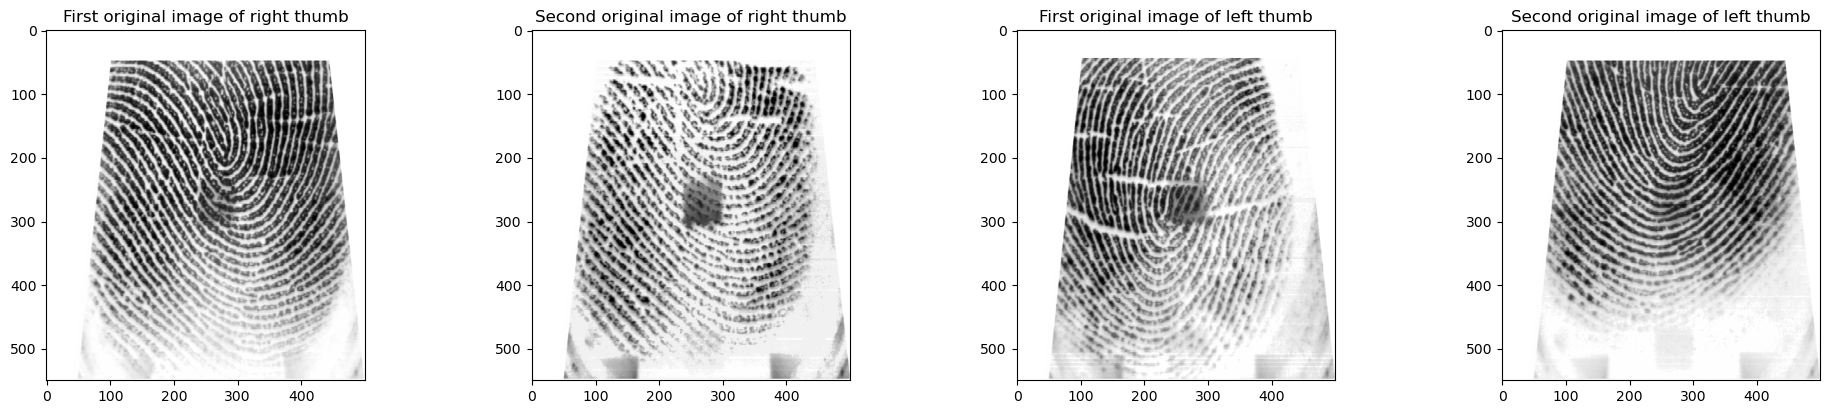

In [1]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
# Pick two images of the right thumb with a difference in quality between the two images
img1_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
img2_right = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

# Pick two images of the left thumb with a difference in quality between the two images
img1_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))
img2_left = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/12.bmp', as_gray=True))

# block size usend for windowed processing
block_size = 16

# for segmentation
seg_threshold = 0.7

# copying the original image in case to use later on
input_img1 = img1_right.copy()
input_img2 = img2_right.copy()
input_img3 = img1_left.copy()
input_img4 = img2_left.copy()

# process each fingerprint image (this will also print the number of minutiae and singularities)
Fp1 = fingerprint_processing(img1_right, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img2_right, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img1_left, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img2_left, block_size=block_size, threshold=seg_threshold)

# Plot the original images (the two right thumb and two left thumb images)
plt.figure(figsize=(24,10))
plt.subplot(2,4,1)
plt.imshow(img1_right); plt.title('First original image of right thumb')
plt.subplot(2,4,2)
plt.imshow(img2_right); plt.title('Second original image of right thumb')
plt.subplot(2,4,3)
plt.imshow(img1_left); plt.title('First original image of left thumb')
plt.subplot(2,4,4)
plt.imshow(img2_left); plt.title('Second original image of left thumb')